In [1]:
!pip install atoti

In [60]:
!pip install pyngrok

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 718.7/718.7 kB 6.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyngrok: filename=pyngrok-7.0.0-py3-none-any.whl size=21129 sha256=c209226199846219d6f2074e8c3eb45807127f087e3b169817666224d07ad8ce
  Stored in directory: /root/.cache/pip/wheels/60/29/7b/f64332aa7e5e88fbd56d4002185ae22dcdc83b35b3d1c2cbf5
Successfully built pyngrok


In [2]:


import atoti as tt
import pandas as pd


Welcome to Atoti 0.8.5!

By using this community edition, you agree with the license available at https://docs.atoti.io/latest/eula.html.
Browse the official documentation at https://docs.atoti.io.
Join the community at https://www.atoti.io/register.

Atoti collects telemetry data, which is used to help understand how to improve the product.
If you don't wish to send usage data, you can request a trial license at https://www.atoti.io/evaluation-license-request.

You can hide this message by setting the `ATOTI_HIDE_EULA_MESSAGE` environment variable to True.


### How will the COVID Season Impact Baseball Stats? -->


## Importing The Data and Wrangling

The dataset used comes from Sean Lahman's website at http://www.seanlahman.com/baseball-archive/statistics/. The work is licensed under a Creative Commons Attribution-ShareAlike 3.0 Unported License.

### **Player Information**

In [3]:
pd.set_option("display.max_columns", None)
player_dt = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/People-v1.csv",
    usecols=[
        "playerID",
        "birthYear",
        "nameGiven",
        "nameLast",
        "nameFirst",
        "bats",
        "throws",
        "debut",
        "finalGame",
    ],
    parse_dates=[
        "debut",
        "finalGame",
    ],
    dtype={"birthYear": "Int64"},
)

In [4]:
player_info = player_dt.copy()

In [5]:
player_info.shape

(19878, 9)

In [6]:
player_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19878 entries, 0 to 19877
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   playerID   19878 non-null  object        
 1   birthYear  19764 non-null  Int64         
 2   nameFirst  19841 non-null  object        
 3   nameLast   19878 non-null  object        
 4   nameGiven  19841 non-null  object        
 5   bats       18698 non-null  object        
 6   throws     18901 non-null  object        
 7   debut      19683 non-null  datetime64[ns]
 8   finalGame  19683 non-null  datetime64[ns]
dtypes: Int64(1), datetime64[ns](2), object(6)
memory usage: 1.4+ MB


The dataset has a lot of late 19th century data that is missing values

In [7]:
player_info.isnull().sum()

playerID        0
birthYear     114
nameFirst      37
nameLast        0
nameGiven      37
bats         1180
throws        977
debut         195
finalGame     195
dtype: int64

In [8]:
player_info.isnull().sum().sum()

2735

In [9]:
player_info[player_info['birthYear'].isnull()]

,playerID,birthYear,nameFirst,nameLast,nameGiven,bats,throws,debut,finalGame
873,barre01,<NA>,John,Barrett,John,NaN,NaN,1872-09-18,1872-10-31
875,barrebi01,<NA>,Bill,Barrett,William,NaN,NaN,1871-07-08,1873-10-18
1327,besti01,<NA>,William,Bestick,William,NaN,NaN,1872-06-20,1872-07-09
1606,bolan01,<NA>,NaN,Boland,NaN,NaN,NaN,1875-09-04,1875-09-04
1676,booth01,<NA>,NaN,Booth,NaN,NaN,NaN,1875-05-01,1875-05-01
...,...,...,...,...,...,...,...,...,...
19309,williwa01,<NA>,Wash,Williams,Washington J.,NaN,NaN,1884-08-05,1885-06-08
19315,wills01,<NA>,NaN,Wills,NaN,NaN,NaN,1884-05-14,1884-07-25
19515,wood01,<NA>,NaN,Wood,NaN,NaN,NaN,1874-09-30,1874-09-30
19721,yostgu01,<NA>,Gus,Yost,August,NaN,NaN,1893-06-12,1893-06-12


In [10]:
# Lets Clean up names
# Get Rid of Blank First and Given Names, records where we dont know when player started


player_info.dropna(subset=["nameFirst", "debut"], inplace=True)
player_info["nameGiven"].fillna("Unknown", inplace=True)

In [11]:
FullName = player_info["nameFirst"] + " " + player_info["nameLast"]
player_info.insert(4, "fullName", FullName )

In [12]:
player_info.head()

,playerID,birthYear,nameFirst,nameLast,fullName,nameGiven,bats,throws,debut,finalGame
0,aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-04-06,2015-08-23
1,aaronha01,1934,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-10-03
2,aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-04-10,1971-09-26
3,aasedo01,1954,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-10-03
4,abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-09-10,2006-04-13


Anticipating that in future analysis we may want to do some analysis where we compare players on "career years" rather than "calendar years". We create a dictionary of the years players debuted for use in the next table.

In [13]:
player_info["debutYear"] = pd.DatetimeIndex(player_info["debut"]).year
player_dtt = player_info

In [14]:
player_dtt.head()

,playerID,birthYear,nameFirst,nameLast,fullName,nameGiven,bats,throws,debut,finalGame,debutYear
0,aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-04-06,2015-08-23,2004
1,aaronha01,1934,Hank,Aaron,Hank Aaron,Henry Louis,R,R,1954-04-13,1976-10-03,1954
2,aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-04-10,1971-09-26,1962
3,aasedo01,1954,Don,Aase,Don Aase,Donald William,R,R,1977-07-26,1990-10-03,1977
4,abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-09-10,2006-04-13,2001


### **Battling Information**

In [15]:
battling_data = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/Batting.csv",
    dtype={
        "RBI": "Int64",
        "SB": "Int64",
        "CS": "Int64",
        "SO": "Int64",
        "IBB": "Int64",
        "HBP": "Int64",
        "SH": "Int64",
        "SF": "Int64",
        "GIDP": "Int64",
    },
)

In [16]:
battling_data

,playerID,yearID,stint,teamID,lgID,G,AB,R,H,2B,3B,HR,RBI,SB,CS,BB,SO,IBB,HBP,SH,SF,GIDP
0,abercda01,1871,1,TRO,NaN,1,4,0,0,0,0,0,0,0,0,0,0,<NA>,<NA>,<NA>,<NA>,0
1,addybo01,1871,1,RC1,NaN,25,118,30,32,6,0,0,13,8,1,4,0,<NA>,<NA>,<NA>,<NA>,0
2,allisar01,1871,1,CL1,NaN,29,137,28,40,4,5,0,19,3,1,2,5,<NA>,<NA>,<NA>,<NA>,1
3,allisdo01,1871,1,WS3,NaN,27,133,28,44,10,2,2,27,1,1,0,2,<NA>,<NA>,<NA>,<NA>,0
4,ansonca01,1871,1,RC1,NaN,25,120,29,39,11,3,0,16,6,2,2,1,<NA>,<NA>,<NA>,<NA>,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107424,zimmejo02,2019,1,DET,AL,23,2,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0
107425,zimmeky01,2019,1,KCA,AL,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
107426,zimmery01,2019,1,WAS,NL,52,171,20,44,9,0,6,27,0,0,17,39,0,0,0,2,4
107427,zobribe01,2019,1,CHN,NL,47,150,24,39,5,0,1,17,0,0,23,24,0,1,0,2,6


In [17]:
battling_data.shape

(107429, 22)

In [18]:
battling_data.rename(
        columns={
        "lgID": "League",
        "G": "Games",
        "AB": "At_Bats",
        "R": "Runs",
        "H": "Hits",
        "2B": "Doubles",
        "3B": "Triples",
        "HR": "Homeruns",
        "RBI": "Runs_Batted_In",
        "SB": "Stolen_Bases",
        "CS": "Caught_Stealing",
        "BB": "Base_on_Balls",
        "SO": "Strikeouts",
        "IBB": "Intentional_walks",
        "HBP": "Hit_by_pitch",
        "SH": "Sacrifice_hits",
        "SF": "Sacrifice_flies",
        "GIDP": "Grounded_into_double_plays",
    },
    inplace=True,
)

In [19]:
battling_data.League.unique()

array([nan, 'NL', 'AA', 'UA', 'PL', 'AL', 'FL'], dtype=object)

In [20]:
# Cull down to just NL and Al Leagues
modern_league_names = ["NL", "AL"]
battling_data = battling_data.loc[battling_data["League"].isin(modern_league_names)].copy()
battling_data.League.unique()

array(['NL', 'AL'], dtype=object)

### **Add Career Season**

In [21]:
debutDict = dict(zip(player_dtt.playerID, player_dtt.debutYear))
battling_data["careerYear"] = battling_data["playerID"].map(debutDict)

In [22]:
battling_data["careerYear"] = battling_data["yearID"] - battling_data["careerYear"] + 1
battling_data["careerYear"] = battling_data["careerYear"].astype(pd.Int32Dtype())
battling_data.head()

,playerID,yearID,stint,teamID,League,Games,At_Bats,Runs,Hits,Doubles,Triples,Homeruns,Runs_Batted_In,Stolen_Bases,Caught_Stealing,Base_on_Balls,Strikeouts,Intentional_walks,Hit_by_pitch,Sacrifice_hits,Sacrifice_flies,Grounded_into_double_plays,careerYear
738,addybo01,1876,1,CHN,NL,32,142,36,40,4,1,0,16,<NA>,<NA>,5,0,<NA>,<NA>,<NA>,<NA>,<NA>,6
739,allisar01,1876,1,LS1,NL,31,130,9,27,2,1,0,10,<NA>,<NA>,2,6,<NA>,<NA>,<NA>,<NA>,<NA>,6
740,allisdo01,1876,1,HAR,NL,44,163,19,43,4,0,0,15,<NA>,<NA>,3,9,<NA>,<NA>,<NA>,<NA>,<NA>,6
741,andrufr01,1876,1,CHN,NL,8,36,6,11,3,0,0,2,<NA>,<NA>,0,5,<NA>,<NA>,<NA>,<NA>,<NA>,1
742,ansonca01,1876,1,CHN,NL,66,309,63,110,9,7,2,59,<NA>,<NA>,12,8,<NA>,<NA>,<NA>,<NA>,<NA>,6


### **Team Information**


Team ID is deceptive, it is not as "human readable" as you would think, lets replace with franchise names (but note that these will be the current franchise name, i.e. Babe Ruth's Boston Braves will show that the team is the current Atlanta Braves)

In [23]:
# Get Franchises and create a dictionary of Franchise ID to name

franchises_df = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/TeamsFranchises.csv"
)

In [24]:
franchises_df.shape

(120, 4)

In [25]:
team_dt = pd.read_csv(
    "http://data.atoti.io/notebooks/baseball/Teams.csv",
    usecols=["yearID", "lgID", "teamID", "franchID"],
)

In [26]:
team_dt = team_dt.rename(columns={'lgID': 'League'})

In [27]:
team_dt

,yearID,League,teamID,franchID
0,1871,NaN,BS1,BNA
1,1871,NaN,CH1,CNA
2,1871,NaN,CL1,CFC
3,1871,NaN,FW1,KEK
4,1871,NaN,NY2,NNA
...,...,...,...,...
2920,2019,NL,SLN,STL
2921,2019,AL,TBA,TBD
2922,2019,AL,TEX,TEX
2923,2019,AL,TOR,TOR


In [28]:
team_dt.shape

(2925, 4)

In [29]:
team_dt = pd.merge(team_dt, franchises_df, on=["franchID"])
team_dt.shape

(2925, 7)

In [30]:
team_dt.rename(columns={"franchName": "teamName"}, inplace=True)
team_dt.head()

,yearID,League,teamID,franchID,teamName,active,NAassoc
0,1871,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
1,1872,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
2,1873,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
3,1874,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL
4,1875,NaN,BS1,BNA,Boston Red Stockings,NaN,ATL


## Create the atoti Cube

In [31]:
si = tt.Session()

In [32]:
player_table = si.read_pandas(
    player_dtt,
    keys=["playerID"],
    table_name="players",
)
player_table.head()


,birthYear,nameFirst,nameLast,fullName,nameGiven,bats,throws,debut,finalGame,debutYear
playerID,,,,,,,,,,
aardsda01,1981,David,Aardsma,David Aardsma,David Allan,R,R,2004-04-06,2015-08-23,2004
aaronto01,1939,Tommie,Aaron,Tommie Aaron,Tommie Lee,R,R,1962-04-10,1971-09-26,1962
abadan01,1972,Andy,Abad,Andy Abad,Fausto Andres,L,L,2001-09-10,2006-04-13,2001
abadijo01,1850,John,Abadie,John Abadie,John W.,R,R,1875-04-26,1875-06-10,1875
abbeybe01,1869,Bert,Abbey,Bert Abbey,Bert Wood,R,R,1892-06-14,1896-09-23,1892


In [33]:
batting_table = si.read_pandas(
    battling_data,
    keys=["playerID", "yearID", "teamID", "League"],
    table_name="batting",
    default_values={"careerYear": 0},
)

batting_table.head()

,,,,stint,Games,At_Bats,Runs,Hits,Doubles,Triples,Homeruns,Runs_Batted_In,Stolen_Bases,Caught_Stealing,Base_on_Balls,Strikeouts,Intentional_walks,Hit_by_pitch,Sacrifice_hits,Sacrifice_flies,Grounded_into_double_plays,careerYear
playerID,yearID,teamID,League,,,,,,,,,,,,,,,,,,,
addybo01,1876,CHN,NL,1,32,142,36,40,4,1,0,16,<NA>,<NA>,5,0,<NA>,<NA>,<NA>,<NA>,<NA>,6
ansonca01,1876,CHN,NL,1,66,309,63,110,9,7,2,59,<NA>,<NA>,12,8,<NA>,<NA>,<NA>,<NA>,<NA>,6
barnero01,1876,CHN,NL,1,66,322,126,138,21,14,1,59,<NA>,<NA>,20,8,<NA>,<NA>,<NA>,<NA>,<NA>,6
battijo01,1876,SL3,NL,1,64,283,34,85,11,4,0,46,<NA>,<NA>,6,6,<NA>,<NA>,<NA>,<NA>,<NA>,6
bechtge01,1876,LS1,NL,1,14,55,2,10,1,0,0,2,<NA>,<NA>,0,1,<NA>,<NA>,<NA>,<NA>,<NA>,6


In [34]:
team_table = si.read_pandas(
    team_dt,
    keys=["yearID", "teamID", "League"],
    table_name="teams",
)

team_table.head()

,,,franchID,teamName,active,NAassoc
yearID,League,teamID,,,,
1871,N/A,BS1,BNA,Boston Red Stockings,N/A,ATL
1872,N/A,BS1,BNA,Boston Red Stockings,N/A,ATL
1874,N/A,BS1,BNA,Boston Red Stockings,N/A,ATL
1875,N/A,BS1,BNA,Boston Red Stockings,N/A,ATL
1874,N/A,CH2,CNA,Chicago White Stockings,N/A,CHC


In [35]:
# atoti automatically maps columns with the same names between 2 datatables
batting_table.join(player_table)


In [36]:
batting_table.join(team_table)

In [37]:
print(
    f"Number of results: {len(player_table)} rows, {len(player_table.columns)} columns"
)

Number of results: 19646 rows, 11 columns


## **Let's create the cube and see the tables look like**

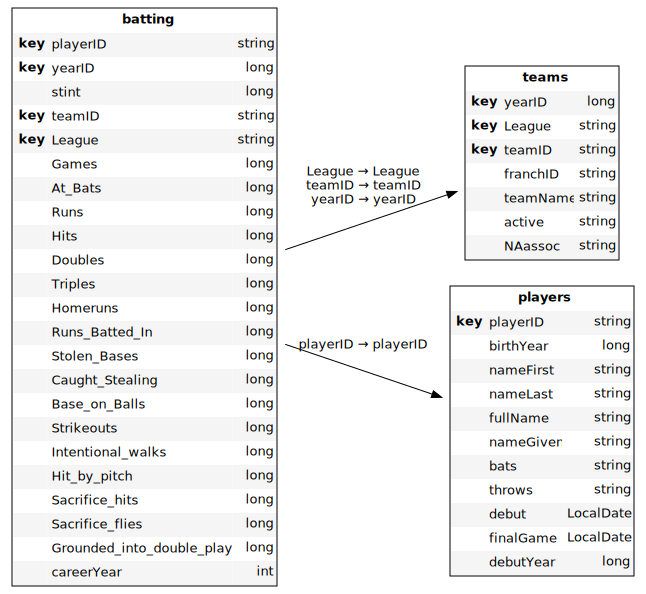

In [38]:
cube = si.create_cube(batting_table, name="Stats", mode="manual")
cube.schema

## **Now Create Hierarchies, Levels and Measures**

In [39]:
h, l, m = cube.hierarchies, cube.levels, cube.measures

In [40]:
h["League"] = [batting_table["League"]]
h["Year"] = [batting_table["yearID"]]
h["Career Year"] = [batting_table["careerYear"]]

# players may have the same name but they will be unique by the playerId

h["Player"] = [player_table["playerID"], player_table["fullName"]]
h["Team"] = [team_table["teamName"]]
h["Debut"] = [player_table["debut"]]
h["Final Game"] = [player_table["finalGame"]]

# Lets Review the hierarchies
h

{('players', 'Debut'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b3d0>, ('players', 'Player'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b430>, ('batting', 'Year'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b520>, ('batting', 'League'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b6d0>, ('teams', 'Team'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b7c0>, ('players', 'Final Game'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b8b0>, ('batting', 'Career Year'): <atoti.hierarchy.Hierarchy object at 0x7b4a6a06b9a0>}

> *In 2020 Major League Baseball season, there are 60 games. We shall use this to project the players' performances.*

We shall see later on how an adjustment in the season length for 2020 will impact the players' performances.






In [41]:
m["2020 Season Length"] = 60
m["500 Home Runs"] = 500
m["Latest Season"] = tt.total(tt.agg.max(batting_table["yearID"]), h["Year"])
m["Latest Season"].formatter = "DOUBLE[####]"

In [42]:
cube.query(m["2020 Season Length"], m["500 Home Runs"], m["Latest Season"])

,2020 Season Length,500 Home Runs,Latest Season
0,60,500,2019


## Player's stats

In [43]:
m["birthYear"] = tt.agg.single_value(player_table["birthYear"])

m["PlayerAge"] = tt.where(
    (~l["playerID"] .isnull()),
    m["Latest Season"] - m["birthYear"],
    None,
)

In [44]:
m["Career Length"] = tt.where(
     (~l["playerID"] .isnull()),
    tt.agg.sum(
        tt.date_diff(l["debut"], l["finalGame"], unit="years"),
        scope=tt.OriginScope(l["finalGame"], l["debut"]),
    ),
    None,
)

In [45]:
m["Games played"] = tt.where(
     (~l["playerID"] .isnull()),
    tt.agg.sum(batting_table["Games"]),
    None,
)

In [46]:
m["Player Season At Bats"] = tt.where(
     (~l["playerID"] .isnull()),
    tt.agg.sum(batting_table["At_Bats"]),
    None,
)

In [49]:
si.visualize("Player's stats")

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

## **Player's homerun stats**

In [75]:
m["Homeruns"] = tt.agg.sum(batting_table["Homeruns"])
m["Homeruns Per Game"] = m["Homeruns"] / m["Games played"]
m["Player Total HR (Year)"] = tt.agg.sum(
    m["Homeruns"], scope=tt.CumulativeScope(level=l["yearID"])
)
m["Career HR"] = tt.agg.sum(
    m["Homeruns"], scope=tt.CumulativeScope(level=l["careerYear"])
)

# projecting player's homerun
m["Median HR"] = tt.agg.mean(
    m["Homeruns Per Game"], scope=tt.OriginScope(l["playerID"])
)
m["Projected HR"] = tt.math.round(m["2020 Season Length"] * m["Median HR"])
m["Projected End Of Season Career HRs"] = (
    m["Player Total HR (Year)"] + m["Projected HR"]
)

In [76]:
si.visualize("Player's homerun stats")

/usr/local/lib/python3.10/dist-packages/atoti_core/base_session.py:113: FutureWarning: `Session.visualize()` is deprecated, use `Session.widget` instead.
  deprecated("`Session.visualize()` is deprecated, use `Session.widget` instead.")


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

## **Player's hit stats**

In [51]:
m["Hits"] = tt.agg.sum(batting_table["Hits"])
m["Hits Per Game"] = m["Hits"] / m["Games played"]
m["Player Total Hits (Year)"] = tt.agg.sum(
    m["Hits"], scope=tt.CumulativeScope(level=l["yearID"])
)
m["Career Hits"] = tt.agg.sum(
    m["Hits"], scope=tt.CumulativeScope(level=l["careerYear"])
)

# projecting player's hits

m["Median Hits"] = tt.agg.mean(m["Hits Per Game"], scope=tt.OriginScope(l["playerID"]))
m["Projected Hits"] = tt.math.round(
    tt.math.round(m["2020 Season Length"] * m["Median Hits"])
)
m["Projected End Of Season Career Hits"] = (
    m["Player Total Hits (Year)"] + m["Projected Hits"]
)

In [57]:
si.widget

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

## The Fun Stuff, the Analysis


How tough getting 500 Home Runs is?

Miguel Cabrera is in striking distance at 477. Nelson Cruz (age 40) and Edwin Encarnación (age 37) have a steep climb to get there, probably needing four excellent seasons; certainly losing 60% of their potential at bats this year may put it out of reach especially for Cruz who would likely have to stay healty and maintain his production till about 44.

In [61]:
si.visualize("Nelson Cruz (age 40) and Edwin Encarnación")

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

In [62]:
si.visualize("Players over 10 Years in League with in top 25% of Career Hits")

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

*Suzuki has retired (he shows as his last game was last year), Pujol is in. Cano at age 38 and 430 hits outs was facing a tough challenge. Looking at his career hit production which is declining, the shortened 2020 season may have put is out of reach. The fact that his hit production and games played crossed last season is not a good sign.*

In [64]:
si.visualize("Robinson Cano Hit Production VS Career Years")

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

*However, the most interesting is Miguel Cabrera, looking at his 2019 stats as the close of 2019*

In [67]:
si.visualize("Cabera End of 2019 Stats")

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

*Cabrera is well within striking distance to joing some excluive company the "500 HR/3000 hits club"! A feat attained by only 6 players in the history of Baseball.*

In [69]:
si.visualize("500 HR/3000 hits club")

/usr/local/lib/python3.10/dist-packages/atoti_core/base_session.py:113: FutureWarning: `Session.visualize()` is deprecated, use `Session.widget` instead.
  deprecated("`Session.visualize()` is deprecated, use `Session.widget` instead.")


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

## **What-if 2020 becomes a standard 162 game season?**

See what the impact of the shortened 2020 season would be assuming that Cabrera "plays to the back of his baseball card" defined as he attains his median hits and home run per game for the season. The base will be the now accepted 60 games season versus a standard 162 game season

In [71]:
# The default value is the current 60 games season
season_simulation = cube.create_parameter_simulation(
    "Impact 2020 Season Length Simulation",
    measures={"Season length parameter": 60},
    base_scenario_name="2020 60 Game Season",
    )

In [72]:
# Use the original measure when the simulated measure is equal to the provided default value
m["Simulated 2020 Season Length"] = tt.where(
    m["Season length parameter"] != 60,
    m["Season length parameter"],
    m["2020 Season Length"],
)

In [73]:
season_simulation += ("Full Length 2020", 162)

*Instead of using the measure Simulated 2020 Season Length to project the number of homeruns, we can update the formula to use the simulation parameter related measure - Simulated 2020 Season Length.*

In [77]:
m["Projected HR"] = tt.math.round(m["Simulated 2020 Season Length"] * m["Median HR"])

In [78]:
si.visualize(
    "Full length 2020 - Impact on player's end of season career hit projection"
)

/usr/local/lib/python3.10/dist-packages/atoti_core/base_session.py:113: FutureWarning: `Session.visualize()` is deprecated, use `Session.widget` instead.
  deprecated("`Session.visualize()` is deprecated, use `Session.widget` instead.")


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

*We can see Edwin Encarnaclon and Nelson Cruz goes closer to the 500 homeruns. The closest however is Miguel Cabrera.*

## **What do Cabrera's projected Numbers look like in the 60 game COVID season versus a normal 162 Game Season?**

In [79]:
si.visualize("Cabrera's projected performance - full length 2020")

/usr/local/lib/python3.10/dist-packages/atoti_core/base_session.py:113: FutureWarning: `Session.visualize()` is deprecated, use `Session.widget` instead.
  deprecated("`Session.visualize()` is deprecated, use `Session.widget` instead.")


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

## **What happens when Covid season is followed by full length 2021?**

So per the assumptions of this analysis, if 2020 was a full season, having a "median year" Cabrera would not get him into the "500 HR/3000 hits club", but he would be very close.
Even if he missed in 2020, getting those landmarks would seem very likely even if Cabrera had an off year in 2021.

The concern is that coming out of the shortened season, what would Cabrera's numbers look like if after a "median" full 162 game season followed a "median" Covid Shortened season? Let's run another simulation, where we project a 60 game season followed by a 162 game season.

In [80]:
season_simulation += ("Covid Season followed by Full Length 2021", 60 + 162)

In [81]:
si.visualize(
    "Cabrera's projected performance - Covid season followed by full length 2021"
)

/usr/local/lib/python3.10/dist-packages/atoti_core/base_session.py:113: FutureWarning: `Session.visualize()` is deprecated, use `Session.widget` instead.
  deprecated("`Session.visualize()` is deprecated, use `Session.widget` instead.")


Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.

*So the COVID shortened Season turns Miguel Cabrera's highly likely induction into the "500 HR/3000 hits club" by the 2021 season under normal circumstanse into a far risky proposition, changing it from an optimistic "one season away" to a potential "three seasons" with all the risks that playing an additional three late career seasons entails.*

                                 **visualize module error**